In [1]:
import re
import torch
import torch.nn as nn
import networkx as nx
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from sklearn.model_selection import train_test_split

In [2]:
# Read the dataset from file
with open("all_individual_data.txt", 'r') as file:
    all_dataset = [line.strip() for line in file]

# Remove duplicates
unique_trees = list(set(all_dataset))

# Print dataset sizes
print(f"Original dataset size: {len(all_dataset)}")
print(f"Unique dataset size: {len(unique_trees)}")

Original dataset size: 1000000
Unique dataset size: 606861


In [3]:
# 3. Define the depth computation function
def compute_tree_depth(tree_expression):
    max_depth = 0
    current_depth = 0
    for char in tree_expression:
        if char == '(':
            current_depth += 1
            if current_depth > max_depth:
                max_depth = current_depth
        elif char == ')':
            if current_depth > 0:
                current_depth -= 1
            else:
                print("Warning: Unbalanced parentheses detected.")
    if current_depth != 0:
        print("Warning: Unbalanced parentheses detected at the end of the expression.")
    return max_depth

# 4. Compute depths
tree_depths = [compute_tree_depth(tree) for tree in unique_trees]

# 5. Define depth thresholds
max_depth = 6

# 6. Filter trees based on depth
filtered_trees = [
    tree for tree, depth in zip(unique_trees, tree_depths) if depth < max_depth
]
# For this example, we'll use depth under 6
unique_trees = filtered_trees

print(f"dataset size: {len(unique_trees)}")
print(unique_trees[:1])

dataset size: 193568
['whileLoop(prog2(whileLoop(movGteA), prog2(readArrayD, readArrayD)))']


In [4]:
def parse_raw_tree(expression, global_label_map=None):
    """
    Parse a raw tree expression into:
        - nodes: a list of integer labels for each node
        - edges: a list of (parent, child) tuples
        - updated_label_map: dict mapping string labels to integer IDs (shared across calls)

    Parameters:
        expression (str): Tree expression to parse.
        global_label_map (dict, optional): A global label map to maintain consistent encoding across trees.

    Returns:
        nodes (list): List of node label IDs.
        edges (list): List of (parent, child) edges.
        updated_label_map (dict): Updated label mapping after processing the tree.
    """

    # Use the provided global label map or create a new one
    if global_label_map is None:
        global_label_map = {}
        label_counter = 0
    else:
        label_counter = max(global_label_map.values(), default=-1) + 1

    stack = []  # Track parent nodes
    nodes = []  # Node labels (integers)
    edges = []  # Parent-child edges

    # Tokenize, allowing letters + digits
    tokens = re.findall(r'[a-zA-Z0-9]+|\(|\)|,', expression)

    last_created_node_id = None

    for token in tokens:
        if token not in ('(', ')', ','):
            # Handle node label
            if token not in global_label_map:
                global_label_map[token] = label_counter
                label_counter += 1
            current_node_label = global_label_map[token]

            # Create a new node with ID = len(nodes)
            node_id = len(nodes)
            nodes.append(current_node_label)

            # Attach to parent if available
            if stack:
                parent_id = stack[-1]
                edges.append((parent_id, node_id))

            last_created_node_id = node_id  # Remember this node

        elif token == '(':
            if last_created_node_id is not None:
                stack.append(last_created_node_id)  # Push parent node
                last_created_node_id = None  # Reset

        elif token == ')':
            if stack:
                stack.pop()  # Pop parent

        # No action needed for ',' since the next node attaches to stack[-1]

    return nodes, edges, global_label_map

In [5]:
def prepare_dataset(raw_trees):
    """
    raw_trees: list of strings (each a tree expression).
    Returns: a list of structured trees and a global label_map.
    """
    global_label_map = {}
    global_counter = 0

    dataset = []
    for expr in raw_trees:
        # parse
        nodes, edges, local_map = parse_raw_tree(expr)

        # unify local_map with global_label_map
        # or if you accept local indexing, you can keep local
        # but let's do global so we handle all tokens consistently.
        new_nodes = []
        for node_label in nodes:
            # node_label is from local map
            # unify with global map
            # e.g., you'd store the string token, not an int
            # so parse_raw_tree might need to store string tokens instead
            # Then here you map them to global integers
            pass

        # build children_dict
        children_dict = {i: [] for i in range(len(nodes))}
        for (p, c) in edges:
            children_dict[p].append(c)

        # find root
        all_children = set(c for (_, c) in edges)
        all_nodes = set(range(len(nodes)))
        root_candidates = all_nodes - all_children
        root_id = min(root_candidates) if root_candidates else 0

        # store
        tree_struct = {
          "root_id": root_id,
          "children_dict": children_dict,
          "labels": new_nodes,  # or if you used local approach, 'nodes'
          "num_nodes": len(nodes)
        }
        dataset.append(tree_struct)

    return dataset, global_label_map

In [6]:
global_label_map = {}  # Shared label map for consistent labels

parsed_trees = []
for expr in unique_trees:
    nodes, edges, global_label_map = parse_raw_tree(expr, global_label_map)
    parsed_trees.append({"expression": expr, "nodes": nodes, "edges": edges})

In [7]:
parsed_trees[:5]

[{'expression': 'whileLoop(prog2(whileLoop(movGteA), prog2(readArrayD, readArrayD)))',
  'nodes': [0, 1, 0, 2, 1, 3, 3],
  'edges': [(0, 1), (1, 2), (2, 3), (1, 4), (4, 5), (4, 6)]},
 {'expression': 'prog2(prog2(prog2(prog2(readArrayD, incI), prog2(movBmaxIter, movGteA)), movBmaxIter), whileLoop(prog2(incI, incI)))',
  'nodes': [1, 1, 1, 1, 3, 4, 1, 5, 2, 5, 0, 1, 4, 4],
  'edges': [(0, 1),
   (1, 2),
   (2, 3),
   (3, 4),
   (3, 5),
   (2, 6),
   (6, 7),
   (6, 8),
   (1, 9),
   (0, 10),
   (10, 11),
   (11, 12),
   (11, 13)]},
 {'expression': 'prog2(movBmaxIter, prog2(prog2(whileLoop(movBmaxIter), incI), whileLoop(whileLoop(whileLoop(swapAD)))))',
  'nodes': [1, 5, 1, 1, 0, 5, 4, 0, 0, 0, 6],
  'edges': [(0, 1),
   (0, 2),
   (2, 3),
   (3, 4),
   (4, 5),
   (3, 6),
   (2, 7),
   (7, 8),
   (8, 9),
   (9, 10)]},
 {'expression': 'prog2(prog2(movBmaxIter, whileLoop(prog2(prog2(readArrayD, incI), movGteA))), whileLoop(whileLoop(prog2(prog2(readArrayD, incI), movGteA))))',
  'nodes': [1,

In [8]:
def convert_to_pyg(data_list):
    """
    Converts a list of trees (dict format) into a list of PyTorch Geometric graph objects.
    """
    pyg_graphs = []

    for data in data_list:
        nodes = torch.tensor(data['nodes'], dtype=torch.float).view(-1, 1)  # Node features
        edges = torch.tensor(data['edges'], dtype=torch.long).t().contiguous()  # Edge index

        graph = Data(x=nodes, edge_index=edges)
        pyg_graphs.append(graph)

    return pyg_graphs


pyg_graphs = convert_to_pyg(parsed_trees)
print(parsed_trees[0])
print(pyg_graphs[0])  # Check the first graph

{'expression': 'whileLoop(prog2(whileLoop(movGteA), prog2(readArrayD, readArrayD)))', 'nodes': [0, 1, 0, 2, 1, 3, 3], 'edges': [(0, 1), (1, 2), (2, 3), (1, 4), (4, 5), (4, 6)]}
Data(x=[7, 1], edge_index=[2, 6])


In [9]:
def add_self_loops_if_needed(graph):
    """
    Adds self-loops to graphs with no edges.
    """
    if graph.edge_index.numel() == 0:  # No edges in the graph
        num_nodes = graph.x.shape[0]  # Get number of nodes
        edge_index = torch.arange(num_nodes, dtype=torch.long).repeat(2, 1)  # Create self-loops
        graph.edge_index = edge_index
    return graph

def fix_dataset(pyg_graphs):
    """
    Fixes a dataset of PyG graphs by adding self-loops to graphs with no edges.
    """
    fixed_graphs = [add_self_loops_if_needed(graph) for graph in pyg_graphs]
    return fixed_graphs

In [10]:
pyg_graphs = fix_dataset(pyg_graphs)
print(pyg_graphs[0])

Data(x=[7, 1], edge_index=[2, 6])


In [11]:
# Split into training and validation sets (80% train, 20% validation)
train_set, val_set = train_test_split(pyg_graphs, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

Training set size: 154854
Validation set size: 38714


In [12]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, in_feats, hidden_size, latent_dim):
        super(GNNEncoder, self).__init__()
        self.conv1 = GCNConv(in_feats, hidden_size)
        self.conv2 = GCNConv(hidden_size, latent_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.2)  # 20% dropout

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = self.dropout(x)  # Applying dropout
        x = self.conv2(x, edge_index)
        return x  # Latent space representation

class MLPDecoder(torch.nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(MLPDecoder, self).__init__()
        self.fc1 = torch.nn.Linear(latent_dim, 32)
        self.fc2 = torch.nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # Reconstructed node features

class Tree2TreeAutoencoder(torch.nn.Module):
    def __init__(self, in_feats, hidden_size, latent_dim, output_dim):
        super(Tree2TreeAutoencoder, self).__init__()
        self.encoder = GNNEncoder(in_feats, hidden_size, latent_dim)
        self.decoder = MLPDecoder(latent_dim, output_dim)

    def forward(self, x, edge_index):
        latent = self.encoder(x, edge_index)
        reconstructed = self.decoder(latent)
        return reconstructed

In [13]:
model = Tree2TreeAutoencoder(in_feats=1, hidden_size=32, latent_dim=16, output_dim=1)
print(model)

Tree2TreeAutoencoder(
  (encoder): GNNEncoder(
    (conv1): GCNConv(1, 32)
    (conv2): GCNConv(32, 16)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): MLPDecoder(
    (fc1): Linear(in_features=16, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [14]:
def compute_accuracy(original, reconstructed):
    """
    Computes reconstruction accuracy as 100 - Mean Absolute Error (MAE) percentage.
    """
    mae = torch.abs(original - reconstructed).mean().item()  # Mean Absolute Error
    scale = torch.abs(original).mean().item()  # Scale by the original mean

    if scale == 0:  # Prevent division by zero
        return 100.0  # If original is all zeros, assume perfect reconstruction

    accuracy = 100 - (mae / scale * 100)  # Lower MAE means higher accuracy
    return max(0, accuracy)  # Ensure accuracy is never negative

In [15]:
def train_autoencoder(graphs, num_epochs=100, patience=10, lr=0.002):
    """
    Trains the Tree2Tree Autoencoder with:
    - Learning Rate Scheduler
    - Dropout Regularization
    - Early Stopping
    - GPU Acceleration
    - Accuracy Calculation (MAPE)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")

    # Move model to GPU
    vae = Tree2TreeAutoencoder(in_feats=1, hidden_size=32, latent_dim=16, output_dim=1).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # Learning rate scheduler (reduce LR every 20 epochs)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    # Early Stopping
    best_loss = float('inf')
    wait = 0

    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0

        for graph in graphs:
            optimizer.zero_grad()

            # Move graph to GPU
            graph = graph.to(device)

            # Forward pass
            reconstructed = vae(graph.x, graph.edge_index)
            loss = loss_fn(reconstructed, graph.x)

            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            # Compute accuracy (MAPE)
            accuracy = compute_accuracy(graph.x, reconstructed)
            total_accuracy += accuracy

        # Adjust learning rate
        scheduler.step()

        avg_loss = total_loss / len(graphs)
        avg_accuracy = total_accuracy / len(graphs)

        # Print loss and accuracy every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Avg Loss: {avg_loss:.6f}, Accuracy: {avg_accuracy:.2f}%')

        # Early stopping logic
        if avg_loss < best_loss:
            best_loss = avg_loss
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    print("Training complete!")
    return vae

trained_model = train_autoencoder(train_set)

Training on: cpu
Epoch 0, Avg Loss: 0.201231, Accuracy: 84.48%
Epoch 10, Avg Loss: 0.184499, Accuracy: 85.14%
Epoch 20, Avg Loss: 0.180336, Accuracy: 85.28%
Epoch 30, Avg Loss: 0.178093, Accuracy: 85.28%
Epoch 40, Avg Loss: 0.177360, Accuracy: 85.31%
Epoch 50, Avg Loss: 0.178036, Accuracy: 85.31%
Epoch 60, Avg Loss: 0.176931, Accuracy: 85.33%
Epoch 70, Avg Loss: 0.178842, Accuracy: 85.33%
Epoch 80, Avg Loss: 0.176679, Accuracy: 85.34%
Epoch 90, Avg Loss: 0.177738, Accuracy: 85.35%
Early stopping triggered at epoch 98
Training complete!


In [16]:
import torch

def test_reconstruction(model, test_graph):
    """
    Tests the trained model by passing a graph and comparing its reconstructed features.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Move test graph to GPU if available
    test_graph = test_graph.to(device)

    # Forward pass
    with torch.no_grad():
        reconstructed = model(test_graph.x, test_graph.edge_index)

    # Compare original vs. reconstructed features
    print("Original Node Features:\n", test_graph.x.cpu().numpy())
    print("Reconstructed Node Features:\n", reconstructed.cpu().numpy())

    return reconstructed

# Select a test graph from dataset
test_graph = pyg_graphs[7]  # Pick any graph

# Test reconstruction
reconstructed_output = test_reconstruction(trained_model, test_graph)

Original Node Features:
 [[1.]
 [1.]
 [5.]
 [0.]
 [1.]
 [1.]
 [2.]
 [2.]
 [4.]
 [0.]
 [2.]]
Reconstructed Node Features:
 [[0.76861656]
 [0.76861656]
 [4.571252  ]
 [0.76861656]
 [0.76861656]
 [0.76861656]
 [2.1644669 ]
 [2.1644669 ]
 [3.7689333 ]
 [0.76861656]
 [0.76861656]]


In [17]:
mse_loss = torch.nn.MSELoss()
error = mse_loss(reconstructed_output, test_graph.x).item()
print(f" Reconstruction Error: {error:.6f}")

 Reconstruction Error: 0.291211


In [20]:
import torch

def evaluate_model(model, val_graphs):
    """
    Evaluates the trained model on the validation set using:
    - MSE Loss
    - Reconstruction Accuracy (MAPE-based)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set to evaluation mode

    loss_fn = torch.nn.MSELoss()
    total_val_loss = 0
    total_val_acc = 0

    with torch.no_grad():  # No gradients needed
        for graph in val_graphs:
            graph = graph.to(device)

            # Forward pass
            reconstructed = model(graph.x, graph.edge_index)

            # Compute loss
            loss = loss_fn(reconstructed, graph.x)
            total_val_loss += loss.item()

            # Compute accuracy
            accuracy = compute_accuracy(graph.x, reconstructed)
            total_val_acc += accuracy

    # Compute averages
    avg_val_loss = total_val_loss / len(val_graphs)
    avg_val_acc = total_val_acc / len(val_graphs)

    print(f"\nModel Evaluation on Validation Set:")
    print(f"Validation Loss (MSE): {avg_val_loss:.6f}")
    print(f"Validation Accuracy: {avg_val_acc:.2f}%")

    return avg_val_loss, avg_val_acc

val_loss, val_accuracy = evaluate_model(trained_model, val_set)



Model Evaluation on Validation Set:
Validation Loss (MSE): 0.265408
Validation Accuracy: 81.98%


In [21]:
import torch
import numpy as np

def extract_latent_vectors(model, graphs):
    """
    Extracts latent vectors from the validation set using the encoder.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    latent_vectors = []
    
    with torch.no_grad():
        for graph in graphs:
            graph = graph.to(device)
            latent_vector = model.encoder(graph.x, graph.edge_index)  # Get encoded representation
            latent_vectors.append(latent_vector.cpu().numpy())

    # Flatten and concatenate all latent vectors
    latent_vectors = np.vstack(latent_vectors)
    return latent_vectors

# 🚀 Extract latent vectors
latent_vectors = extract_latent_vectors(trained_model, val_set)
print(f"Extracted {latent_vectors.shape[0]} latent vectors with {latent_vectors.shape[1]} dimensions")

Extracted 552660 latent vectors with 16 dimensions


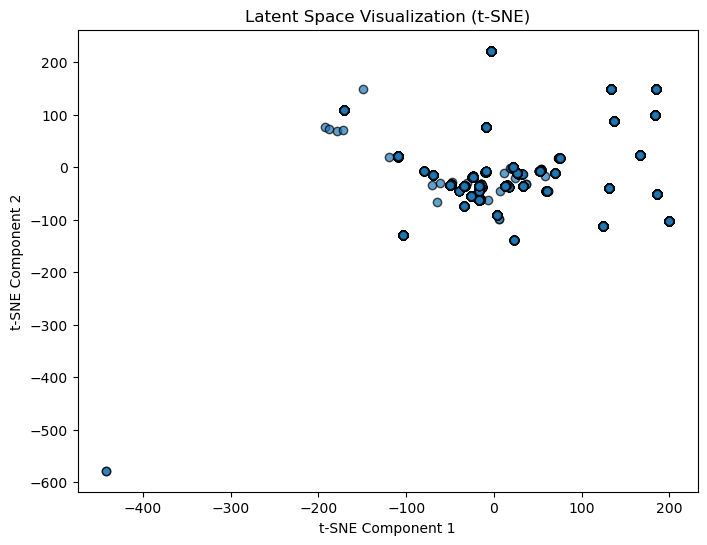

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_vectors_tsne = tsne.fit_transform(latent_vectors)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(reduced_vectors_tsne[:, 0], reduced_vectors_tsne[:, 1], alpha=0.7, edgecolors="k")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Latent Space Visualization (t-SNE)")
plt.show()